5. Kaggle1_RoBERTa_Classification
•	RoBERTa Fine-Tuned on Data1 toddler


- Soo Kyung Bae(Scarlett), Ph.D. Student
- Dept. of Integrated Medicine(Major in Digital Healthcare)
- Yonsei University College of Medicine

In [1]:
# 1. 라이브러리 및 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import random
from transformers import Trainer
from transformers import RobertaTokenizerFast
from transformers import RobertaForSequenceClassification
from transformers import TrainingArguments
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import seaborn as sns

/opt/anaconda3/envs/RoBERTa2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 데이터 불러오기

data_total = pd.read_csv('./output/QCHAT_T_ASD_total_First.csv')
data_total=data_total[['Class/ASD Traits','text']] # 데이터셋에서 Class/ASD Traits 와 text column만 사용

# 결과
print("QCHAT label_encoded counts: ", data_total['Class/ASD Traits'].value_counts())
data_total.head()

QCHAT label_encoded counts:  Class/ASD Traits
1    110
0     44
Name: count, dtype: int64


,Class/ASD Traits,text
0,0,", , , , , , , , ,"
1,0,", , , , , , , , ,"
2,0,", , , , , , , , ,"
3,0,", , , , , , , , ,"
4,0,", , , , , , , , ,"


In [3]:
# 시드값 설정

if torch.cuda.is_available(): 
    print("GPU is available")

#set random seed 
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    # torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
random_seed = 42
set_seed(random_seed)
SEED = 42

In [5]:
# 3. train-test-validation split (5.6:1.4:3)

In [4]:
# X: input variables, y: target variable
X = data_total.drop('Class/ASD Traits', axis=1)
y = data_total['Class/ASD Traits']

# train-test split(7:3)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

train_and_validation_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True) # test dataset

# train-validation split(8:2)

# X: input variables, y: target variable
X = train_and_validation_df.drop('Class/ASD Traits', axis=1)
y = train_and_validation_df['Class/ASD Traits']

# Split the training data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)

train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True) # training dataset
valid_df = pd.concat([X_valid, y_valid], axis=1).reset_index(drop=True) # validation dataset

In [5]:
print("size of train dataset: ", len(train_df))
print("size of validation dataset: ", len(valid_df))
print("size of test dataset: ", len(test_df))

size of train dataset:  85
size of validation dataset:  22
size of test dataset:  47


In [8]:
# 4. Tokenization

In [6]:
# Tokenization에 사용될 모델 
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

# train set tokenization
encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=512)
train_labels = train_df['Class/ASD Traits'].tolist()
train_input_ids = encodings['input_ids']
train_attention_masks = encodings['attention_mask']

# validation set tokenization
encodings = tokenizer(valid_df['text'].tolist(), truncation=True, padding=True, max_length=512)
valid_labels = valid_df['Class/ASD Traits'].tolist()
valid_input_ids = encodings['input_ids']
valid_attention_masks = encodings['attention_mask']

# test set tokenization
encodings = tokenizer(test_df['text'].tolist(), padding=True, truncation=True, return_tensors="pt")
test_input_ids = encodings['input_ids']
test_attention_masks = encodings['attention_mask']

/opt/anaconda3/envs/RoBERTa2/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
# Before
print("text example from train BEFORE tokenization: ")
print(train_df['text'][0])

text example from train BEFORE tokenization: 
 , , , , , , , , ,


In [8]:
# After
print("text example from train AFTER tokenization: ")
print("Input Ids: ", train_input_ids[0])
print("attention mask: ", train_attention_masks[0])

text example from train AFTER tokenization: 
Input Ids:  [0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
attention mask:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [9]:
# 5. New dataset class for Training Process

In [9]:
# training에 사용하기 위해 데이터 타입 전환

# Training에 사용될 데이터 class
class QCHATDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __getitem__(self, idx):
        # training 과정에서 데이터가 사용될 때 tensor 타입으로 사용되도록 합니다. 
        
        print(self.input_ids[idx])
        
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

    def __len__(self):
        return len(self.labels)


# train set
train_dataset = QCHATDataset(train_input_ids, train_attention_masks, train_labels)
# Validation set
validation_dataset = QCHATDataset(valid_input_ids, valid_attention_masks, valid_labels)
# test dataset
test_dataset = QCHATDataset(test_input_ids, test_attention_masks, test_df['Class/ASD Traits'].tolist())

In [10]:
# After
train_dataset[0]

[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


{'input_ids': tensor([   0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156,    2,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(0)}

In [13]:
# 6. Model Build

In [10]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ['TORCH_USE_CUDA_DSA']='1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# RoBERTa Classification 기본 모델을 불러옵니다.
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Training에 사용될 hyperparameter을 설정해줍니다.
training_args = TrainingArguments(
    output_dir='./output', #         # output directory for model checkpoints
    num_train_epochs=5,              # number of training epochs
    per_device_train_batch_size = 16,  # batch size for training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=0,                # number of warmup steps
    weight_decay=1e-8,               # strength of weight decay
    logging_dir='./Roberta/log',            # directory for storing logs
    logging_steps=10,              # log saving step. 100
    evaluation_strategy="epoch",     # evaluate each `logging_steps`,
    learning_rate=2e-5,              # learning rate

)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/RoBERTa2/lib/python3.9/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
# Training에 사용할 evaluation metrics를 설정해줍니다.

def compute_metrics_multiclass(p, num_classes=2):  # num_classes는 예시 값입니다. 실제 클래스 수로 변경하세요.
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    # Multiclass
    f1 = f1_score(labels, predictions, average='macro')
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)

    # Treat each class as a binary classification
    labels_binarized = label_binarize(labels, classes=range(num_classes))
    predictions_binarized = label_binarize(predictions, classes=range(num_classes))

    # Multiclass AUROC , Average Precision
    auroc = roc_auc_score(labels_binarized, predictions_binarized, multi_class='ovr')
    avgprc = average_precision_score(labels_binarized, predictions_binarized)

    return {
        "acc": acc, 
        "f1": f1, 
        "precision": precision, 
        "recall": recall, 
        "auroc": auroc, 
        "avgprc": avgprc
    }

def compute_metrics_wrapper(p):
    return compute_metrics_multiclass(p, num_classes=2) #0,1


In [12]:
# Training에 필요한 데이터셋, model, evaluation_metrics, hyperparameter 등을 주어줍니다.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics_wrapper  # We will define compute_metrics function later
)

# Training을 시작합니다.
trainer.train()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  0%|          | 0/30 [00:00<?, ?it/s]

[0, 2156, 2156, 2156, 2156, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 32278, 48284, 4356, 22257, 12433, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 87, 30830, 106, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2300, 1

  7%|▋         | 2/30 [00:00<00:08,  3.17it/s]

[0, 2611, 19774, 8, 11772, 3781, 2156, 2156, 2156, 2300, 154, 7, 5486, 773, 2156, 26692, 17050, 310, 2156, 1193, 17274, 1503, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 10155, 1342, 1901, 2156, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 87, 30830, 106, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 4182, 2533, 43320, 7547, 2156, 2300, 154, 7, 5486, 773, 2156, 26692, 17050, 310, 2156, 1193, 17274, 1503, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 87, 30830, 106, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

 13%|█▎        | 4/30 [00:00<00:05,  4.98it/s]

[0, 2156, 10800, 19170, 2295, 2156, 2156, 2156, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 87, 30830, 106, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 10155, 1342, 1901, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 1193, 17274, 1503, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 10155, 1342, 1901, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

 20%|██        | 6/30 [00:01<00:04,  5.13it/s]

[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2300, 154, 7, 5486, 773, 2156, 26692, 17050, 310, 2156, 1193, 17274, 1503, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 32278, 48284, 4356, 22257, 12433, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 4182, 2533, 43320, 7547, 2156, 2300, 154, 7, 5486, 773, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 1193, 17274, 1503, 2156, 2156, 2156, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 87, 30830, 106, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

/opt/anaconda3/envs/RoBERTa2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                              
 20%|██        | 6/30 [00:01<00:04,  5.13it/s]

[0, 2156, 2156, 2156, 2156, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 32278, 48284, 4356, 22257, 12433, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2611, 19774, 8, 11772, 3781, 2156, 10800, 19170, 2295, 2156, 2156, 2156, 2156, 1193, 17274, 1503, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 87, 30830, 106, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

 27%|██▋       | 8/30 [00:01<00:04,  4.67it/s]

[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 10800, 19170, 2295, 2156, 2156, 2300, 154, 7, 5486, 773, 2156, 26692, 17050, 310, 2156, 2156, 19027,

 33%|███▎      | 10/30 [00:02<00:03,  5.62it/s]

[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2611, 19774, 8, 11772, 3781, 2156, 10800, 19170, 2295, 2156, 4182, 2533, 43320, 7547, 2156, 2300, 154, 7, 5486, 773, 2156, 26692, 17050, 310, 2156, 1193, 17274, 1503, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 10155, 1342, 1901, 2156, 32278, 48284, 4356, 22257, 12433, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

 37%|███▋      | 11/30 [00:02<00:03,  5.85it/s]

[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2300, 154, 7, 5486, 773, 2156, 26692, 17050, 310, 2156, 1193, 17274, 1503, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 32278, 48284, 4356, 22257, 12433, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 4182, 2533, 43320, 7547, 2156, 2300, 154, 7, 5486, 773, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 1193, 17274, 1503, 2156, 2156, 2156, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 87, 30830, 106, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

/opt/anaconda3/envs/RoBERTa2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                               
 40%|████      | 12/30 [00:02<00:03,  5.85it/s]

[0, 2156, 2156, 2156, 2156, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 32278, 48284, 4356, 22257, 12433, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2611, 19774, 8, 11772, 3781, 2156, 10800, 19170, 2295, 2156, 2156, 2156, 2156, 1193, 17274, 1503, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 87, 30830, 106, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

 43%|████▎     | 13/30 [00:02<00:02,  6.18it/s]

[0, 2611, 19774, 8, 11772, 3781, 2156, 10800, 19170, 2295, 2156, 2156, 2300, 154, 7, 5486, 773, 2156, 2156, 1193, 17274, 1503, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 87, 30830, 106, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2611, 19774, 8, 11772, 3781, 2156, 10800, 19170, 2295, 2156, 2156, 2156, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2611, 19774, 8, 11772, 3781, 2156, 10800, 19170, 2295, 2156, 4182, 2533, 43320, 7547, 2156, 2300, 154, 7, 5486, 773, 2156, 2156, 1193, 17274, 1503, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 10155, 1342, 1901, 2156, 32278, 48284, 4356, 22257, 12433, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 87, 30830, 106, 2, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 21

 47%|████▋     | 14/30 [00:02<00:02,  6.35it/s]

[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2611, 19774, 8, 11772, 3781, 2156, 10800, 19170, 2295, 2156, 2156, 2300, 154, 7, 5486, 773, 2156, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2611, 19774, 

 50%|█████     | 15/30 [00:02<00:02,  6.49it/s]

[0, 2156, 2156, 4182, 2533, 43320, 7547, 2156, 2300, 154, 7, 5486, 773, 2156, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 32278, 48284, 4356, 22257, 12433, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 87, 30830, 106, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 1193, 17274, 1503, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 87, 30830, 106, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 10800, 19170, 2295, 2156, 2156, 2300, 154, 7, 5486, 773, 2156, 26692, 17050, 310, 2156, 1193, 17274, 1503, 2156, 19027, 10405, 18741, 11, 592, 7

 53%|█████▎    | 16/30 [00:03<00:02,  6.53it/s]

[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 10155, 1342, 1901, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2611, 19774, 8, 11772, 3781, 2156, 10800, 19170, 2295, 2156, 2156, 2300, 154, 7, 5486, 773, 2156, 26692, 17050, 310, 2156, 1193, 17274, 1503, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 10155, 1342, 1901, 2156, 32278, 48284, 4356, 22257, 12433, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 87, 30830, 106, 2, 1, 1, 1, 1]
[0, 2611, 19774, 8, 11772, 3781, 2156, 10800, 19170, 2295, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 5785, 18741, 40782, 15818, 352, 23, 31

 57%|█████▋    | 17/30 [00:03<00:01,  6.57it/s]

[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2300, 154, 7, 5486, 773, 2156, 26692, 17050, 310, 2156, 1193, 17274, 1503, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 32278, 48284, 4356, 22257, 12433, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 4182, 2533, 43320, 7547, 2156, 2300, 154, 7, 5486, 773, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 1193, 17274, 1503, 2156, 2156, 2156, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 87, 30830, 106, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

/opt/anaconda3/envs/RoBERTa2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                               
 60%|██████    | 18/30 [00:03<00:01,  6.57it/s]

[0, 2156, 2156, 2156, 2156, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 32278, 48284, 4356, 22257, 12433, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2611, 19774, 8, 11772, 3781, 2156, 10800, 19170, 2295, 2156, 2156, 2156, 2156, 1193, 17274, 1503, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 87, 30830, 106, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

 63%|██████▎   | 19/30 [00:03<00:01,  6.53it/s]

[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 87, 30830, 106, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 4182, 2533, 43320, 7547, 2156, 2300, 154, 7, 5486, 773, 2156, 26692, 17050, 310, 2156, 1193, 17274, 1503, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 

 67%|██████▋   | 20/30 [00:03<00:01,  6.54it/s]

{'loss': 0.4942, 'grad_norm': 2.336968421936035, 'learning_rate': 6.666666666666667e-06, 'epoch': 3.33}
[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 87, 30830, 106, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 10800, 19170, 2295, 2156, 2156, 2300, 154, 7, 5486, 773, 2156, 26692, 17050, 310, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2611, 19774, 8, 11772, 3781, 2156, 10800, 19170, 2295, 2156, 2156, 2156, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2611, 19774, 8, 11772, 3781, 2156, 2156, 4182, 2533, 43320, 7547, 2156, 2300, 154, 7,

 70%|███████   | 21/30 [00:03<00:01,  6.59it/s]

[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2300, 154, 7, 5486, 773, 2156, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 32278, 48284, 4356, 22257, 12433, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 87, 30830, 106, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 2

 73%|███████▎  | 22/30 [00:03<00:01,  6.63it/s]

[0, 2156, 2156, 2156, 2156, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 2156, 190

 77%|███████▋  | 23/30 [00:04<00:01,  6.66it/s]

[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2300, 154, 7, 5486, 773, 2156, 26692, 17050, 310, 2156, 1193, 17274, 1503, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 32278, 48284, 4356, 22257, 12433, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 4182, 2533, 43320, 7547, 2156, 2300, 154, 7, 5486, 773, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 1193, 17274, 1503, 2156, 2156, 2156, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 87, 30830, 106, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

/opt/anaconda3/envs/RoBERTa2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                               
 80%|████████  | 24/30 [00:04<00:00,  6.66it/s]

[0, 2156, 2156, 2156, 2156, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 32278, 48284, 4356, 22257, 12433, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2611, 19774, 8, 11772, 3781, 2156, 10800, 19170, 2295, 2156, 2156, 2156, 2156, 1193, 17274, 1503, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 87, 30830, 106, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

 83%|████████▎ | 25/30 [00:04<00:00,  6.56it/s]

[0, 2611, 19774, 8, 11772, 3781, 2156, 10800, 19170, 2295, 2156, 2156, 2300, 154, 7, 5486, 773, 2156, 26692, 17050, 310, 2156, 1193, 17274, 1503, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 10155, 1342, 1901, 2156, 32278, 48284, 4356, 22257, 12433, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 87, 30830, 106, 2, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 10155, 1342, 1901, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 10155, 1342, 1901, 2156, 2156, 2, 1, 1, 

 87%|████████▋ | 26/30 [00:04<00:00,  6.56it/s]

[0, 2611, 19774, 8, 11772, 3781, 2156, 10800, 19170, 2295, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 87, 30830, 106, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2611, 19774, 8, 11772, 3781, 2156, 10800, 19170, 2295, 2156, 2156, 2300, 154, 7, 5486, 773, 2156, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

 90%|█████████ | 27/30 [00:04<00:00,  6.62it/s]

[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 87, 30830, 106, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2300, 154, 7, 5486, 773, 2156, 26692, 17050, 310, 2156, 1193, 17274, 1503, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 32278, 48284, 4356, 22257, 12433, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 10800, 19170, 2295, 2156, 4182, 2533, 43320, 7547, 2156, 2156, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 87, 30830, 106

 93%|█████████▎| 28/30 [00:04<00:00,  6.68it/s]

[0, 2156, 2156, 2156, 2156, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 87, 30830, 106, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 10800, 19170, 2295, 2156, 2156, 2300, 154, 7, 5486, 773, 2156, 26692, 17050, 310, 2156, 1193, 17274, 1503, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

100%|██████████| 30/30 [00:05<00:00,  6.68it/s]

{'loss': 0.5024, 'grad_norm': 4.056088924407959, 'learning_rate': 0.0, 'epoch': 5.0}
[0, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2300, 154, 7, 5486, 773, 2156, 26692, 17050, 310, 2156, 1193, 17274, 1503, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 32278, 48284, 4356, 22257, 12433, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 4182, 2533, 43320, 7547, 2156, 2300, 154, 7, 5486, 773, 2156, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 1193, 17274, 1503, 2156, 2156, 2156, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 87, 3

/opt/anaconda3/envs/RoBERTa2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                               
100%|██████████| 30/30 [00:06<00:00,  4.46it/s]

[0, 2156, 2156, 2156, 2156, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 32278, 48284, 4356, 22257, 12433, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2611, 19774, 8, 11772, 3781, 2156, 10800, 19170, 2295, 2156, 2156, 2156, 2156, 1193, 17274, 1503, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 5785, 18741, 40782, 15818, 352, 23, 310, 8720, 1195, 87, 30830, 106, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 2156, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 2156, 2156, 2156, 2156, 26692, 17050, 310, 2156, 2156, 19027, 10405, 18741, 11, 592, 73, 991, 23745, 31516, 1571, 2156, 2156, 2156, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

TrainOutput(global_step=30, training_loss=0.5559359868367513, metrics={'train_runtime': 6.7402, 'train_samples_per_second': 63.055, 'train_steps_per_second': 4.451, 'total_flos': 13977774816000.0, 'train_loss': 0.5559359868367513, 'epoch': 5.0})

In [17]:
# Evaluation 
trainer.evaluate()

  0%|          | 0/3 [00:00<?, ?it/s]/opt/anaconda3/envs/RoBERTa/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 3/3 [00:00<00:00, 76.07it/s]


{'eval_loss': 0.6144886612892151,
 'eval_acc': 0.7272727272727273,
 'eval_f1': 0.42105263157894735,
 'eval_precision': 0.36363636363636365,
 'eval_recall': 0.5,
 'eval_auroc': 0.5,
 'eval_avgprc': 0.7272727272727273,
 'eval_runtime': 0.1602,
 'eval_samples_per_second': 137.32,
 'eval_steps_per_second': 18.726,
 'epoch': 5.0}

In [18]:
# 6. fine-tuning된 모델 저장하기 및 불러오기

In [19]:
# save model
trainer.save_model("./output/Roberta/ROBERTA_qchatmodel_score_edited")

# load model
# model = AutoModelForSequenceClassification.from_pretrained("./Roberta/ROBERTA_qchatmodel_Feb2024")


In [22]:
# 7. Prediction and Evaluation

In [20]:
# Prediction

# Generate predictions
predictions_output = trainer.predict(test_dataset)

# prediciton and label
predictions = np.argmax(predictions_output.predictions, axis=-1)
true_labels = predictions_output.label_ids

/var/folders/4f/9jwcfl7s6sz9pnhpf52ybf500000gn/T/ipykernel_63242/31615990.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
/var/folders/4f/9jwcfl7s6sz9pnhpf52ybf500000gn/T/ipykernel_63242/31615990.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
100%|██████████| 6/6 [00:00<00:00, 30.21it/s]/opt/anaconda3/envs/RoBERTa/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

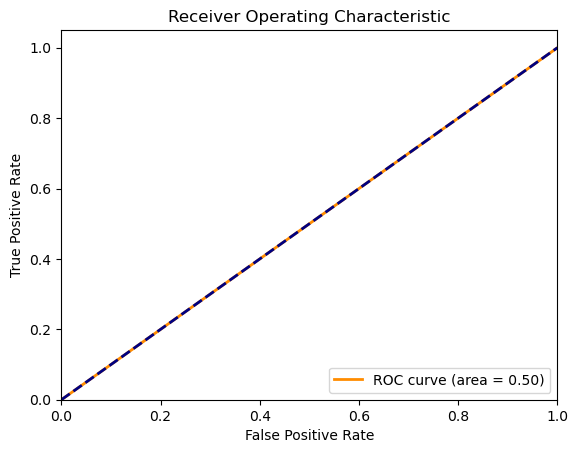

In [21]:
# auroc

# ROC curve , ROC area calculation
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

# ROC curve 
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

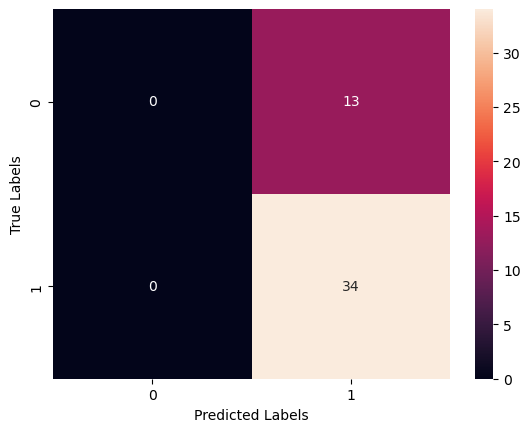

In [22]:
# Preciction Results heatmap

df_results = pd.DataFrame({'True_Labels': true_labels, 'Predictions': predictions})

# Compute confusion matrix
conf_matrix = confusion_matrix(df_results['True_Labels'], df_results['Predictions'])

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

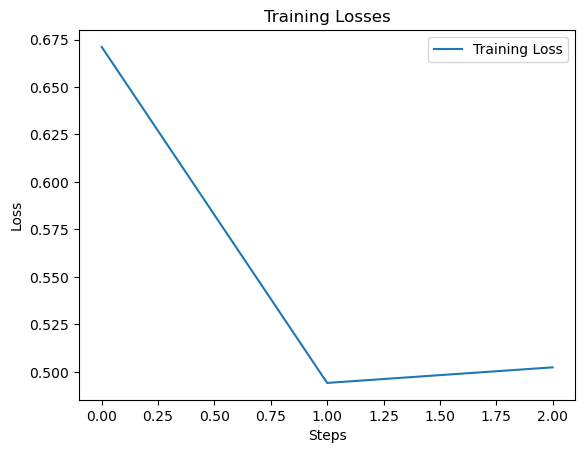

In [23]:
# training losses Evaluation

# log result: training 과정 기록
log_result = trainer.state.log_history

train_losses = []
eval_losses = []
for elem in log_result:
      if 'loss' in elem.keys():
        train_losses.append(elem['loss'])

# Plot the training and validation losses
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()